# Validation of t-SNE overlap approach
Make t-SNE of all freesolv quintuplicates. Make a split such that the test quints are not well-represented in the training set. Check if these are poorly predicted on by a model. Then incrementally add back the most un-represented cases and update statistics. 

In [1]:
import glob
import csv
import re
import pandas as pd
import itertools
import numpy as np
from tqdm.notebook import tqdm
import csv
import matplotlib.pyplot as plt 
import seaborn as sns 
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

import sklearn
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy import stats

import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from tensorflow import keras
from tensorflow.keras import layers

from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdFMCS, AllChem, rdmolfiles, Descriptors, rdchem

In [2]:
quints_fps = pd.read_csv("output/quints_fps.csv", header=None)
quints_infos = pd.read_csv("output/quints_infos.csv", names=["set", "pertname", "pertsmarts", "num_ha", "sem"])

quints_whole_df = pd.concat([quints_infos, quints_fps], axis=1)

# drop NaN columns (happens with molprop generation where (error) strings can't be subtracted)
quints_whole_df = quints_whole_df.dropna(axis=1)

# drop rows where SEM == 0.0. It seems some very large perturbations get this value too, so makes training noisy.
quints_whole_df = quints_whole_df[quints_whole_df["sem"] > 0.0001]

# drop columns where all values are 0.
quints_whole_df = quints_whole_df.loc[:, (quints_whole_df != 0).any(axis=0)]

# TMP DROP DUPLICATES --> should be fewer duplicates when we move up to more features.
quints_whole_df = quints_whole_df.drop_duplicates(subset=quints_whole_df.columns.difference(['sem','set','pertname','pertsmarts']))

quints_whole_df

,set,pertname,pertsmarts,num_ha,sem,1,4,5,8,10,...,71,72,73,74,75,77,78,79,80,81
0,TrainingSet,mobley_1662128~mobley_7047032,[C*]C~[C*]C.[C*]Cl,2,0.156846,0,0,1,1,0,...,0.2173,5.0240,0.00,2.5,-0.222222,33.961028,2.425788,6,-1,10.0
1,TrainingSet,mobley_7047032~mobley_1662128,[C*]C.[C*]Cl~[C*]C,2,0.156846,0,0,-1,-1,0,...,-0.2173,-5.0240,0.00,-2.5,0.222222,-33.961028,-2.425788,-6,1,-10.0
2,TrainingSet,mobley_7015518~mobley_303222,[C*]OC~[C*]CC,1,0.108653,0,2,0,-1,1,...,1.1537,3.0320,-9.23,0.0,0.000000,-1.979265,-1.110072,0,0,0.0
3,TrainingSet,mobley_303222~mobley_7015518,[C*]CC~[C*]OC,1,0.108653,0,-2,0,1,-1,...,-1.1537,-3.0320,9.23,0.0,0.000000,1.979265,1.110072,0,0,0.0
4,TrainingSet,mobley_1046331~mobley_3515580,[C*]O~[C*]O,1,0.113167,0,0,0,0,0,...,-0.3492,0.2280,0.00,0.5,0.666667,0.000000,0.000000,-8,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5365,TrainingSet,mobley_5326154~mobley_1019269,[C*]N(C)C1CCCCC1~[C*]CCCO,8,0.155166,-1,-11,-4,0,-4,...,-1.1019,-18.5662,16.99,-1.0,-0.666667,-53.062935,0.048361,-68,-7,-26.0
5366,TrainingSet,mobley_1019269~mobley_7774695,[C*]CCCO~[C*]NC1CCCCC1,7,0.119793,1,8,3,0,3,...,0.7597,13.9389,-8.20,0.5,0.222222,39.047285,-0.019931,44,5,20.0
5367,TrainingSet,mobley_7774695~mobley_1019269,[C*]NC1CCCCC1~[C*]CCCO,7,0.119793,-1,-8,-3,0,-3,...,-0.7597,-13.9389,8.20,-0.5,-0.222222,-39.047285,0.019931,-44,-5,-20.0
5368,TrainingSet,mobley_1019269~mobley_1189457,[C*]CCCO~[C*]SC1CCCCC1,7,0.281720,0,7,3,0,3,...,1.9033,18.3942,5.07,0.5,0.222222,56.008457,0.974590,44,5,20.0


### Discretize SEM label into categorical bins

In [3]:
### TMP DISCRETIZE BY STRATIFICATION:
n_bins=10

binned_sem = pd.qcut(quints_whole_df["sem"], n_bins, labels=False)
bin_means = []
quints_whole_df["sem_bin"] = binned_sem
print("Bin, Min, Max, Volume")
for n_bin, df_group in quints_whole_df.groupby(by="sem_bin"):
    print(n_bin, round(min(df_group["sem"].values), 2), round(max(df_group["sem"].values), 2), len(df_group))
    bin_means.append(np.mean(df_group["sem"].values))

Bin, Min, Max, Volume
0 0.01 0.05 357
1 0.05 0.07 358
2 0.07 0.1 356
3 0.1 0.12 356
4 0.12 0.15 358
5 0.15 0.19 356
6 0.19 0.26 356
7 0.26 0.49 356
8 0.49 1.47 358
9 1.47 97.24 356


In [4]:
### TMP SLIM DOWN DOMINANT CLASSES
# quints_whole_df.sort_values(by="sem_bin")
# quints_whole_df = quints_whole_df.groupby("sem_bin").head(100)



In [5]:
quints_fps = quints_whole_df.drop(["set", "pertname", "pertsmarts", "num_ha", "sem", "sem_bin"], axis=1)
quints_fps = quints_fps.values
quints_infos = quints_whole_df[["set", "pertname", "pertsmarts", "num_ha", "sem", "sem_bin"]]

In [6]:
def fitTSNE(fps):

    # https://iwatobipen.wordpress.com/2019/12/22/clustering-molecules-with-hdbscan-and-predict-chemical-space-with-scikit-learn-chemoinformatics-rdkit/
    tsne = TSNE(random_state=42)

    res = tsne.fit_transform(fps)
    
    return res

In [7]:
res = fitTSNE(quints_fps)

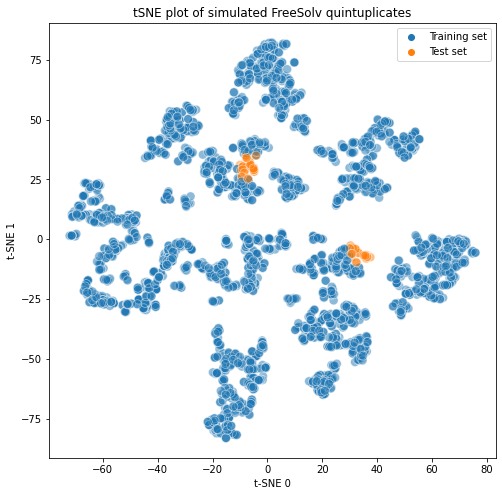

In [8]:
upper_test_indices = []
lower_test_indices = []
train_indices = []

colours = []

for i, (x, y) in enumerate(zip(res[:,0], res[:,1])):
    if 30 < x < 40 and -10 < y < 5:
        upper_test_indices.append(i)
        colours.append("Test set")
    elif -10 < x < -2 and 25 < y < 35:
        lower_test_indices.append(i)
        colours.append("Test set")
    else:
        train_indices.append(i)
        colours.append("Training set")

plt.figure(figsize=(8, 8))
sns.scatterplot(x=res[:,0], y=res[:,1], hue=colours, **plot_kwds)

plt.xlabel("t-SNE 0")
plt.ylabel("t-SNE 1")
plt.title("tSNE plot of simulated FreeSolv quintuplicates")
plt.show()

### Split into train (orange) and test (blue)

In [9]:
def takeSubset(indices, quints_whole_df):
    """Take a selection of a dataframe using indices"""
    subset = quints_whole_df.iloc[indices]
    
    return subset
    

In [10]:
def takeInfo(perts_df):
    """from the input dataframe, return arrays of fingerprints and SEMs"""
    sems = perts_df[["sem_bin", "sem"]].values
    
    # fps is a bit more involved. Remove everything but the FP columns, return as 2d array.
    fps_df = perts_df.drop(["set", "pertname", "pertsmarts", "num_ha", "sem", "sem_bin"], axis=1)
    fps = fps_df.values

    return fps, sems

In [11]:
def preProcessSets(test1, test2, train):
    """standardises and reduces dimensionality to 95% VE; returns arrays"""
    
    #### fit the scaler on training set.
    scaler = preprocessing.StandardScaler()
    train_scaled = scaler.fit_transform(train)
    
    # transform both the training set and the test sets.
    test1_scaled = scaler.transform(test1)
    test2_scaled = scaler.transform(test2)
    
    #### fit PCA on training set with 95% variance explained.
    pca = PCA(n_components=0.95)
    train_preprocessed = pca.fit_transform(train_scaled)
    
    # transform both the training set and the test sets.
    test1_preprocessed = pca.transform(test1_scaled)
    test2_preprocessed = pca.transform(test2_scaled)
    
    return test1_preprocessed, test2_preprocessed, train_preprocessed

In [12]:
# get fps, sem, preprocess (i.e. scale and reduce dimensionality)
# upper_test_fps, upper_test_sems = takeInfo(takeSubset(upper_test_indices, quints_whole_df))
# lower_test_fps, lower_test_sems = takeInfo(takeSubset(lower_test_indices, quints_whole_df))
# train_fps, train_sems = takeInfo(takeSubset(train_indices, quints_whole_df))

# test_set1, test_set2, train_set = preProcessSets(upper_test_fps, lower_test_fps, train_fps)

# n_classes = len(set(train_sems))


In [13]:
## TMP RANDOM SPLIT INSTEAD OF TSNE SPLIT
from sklearn.model_selection import train_test_split
whole_set, whole_set_sem_bins = takeInfo(takeSubset(np.array(range(len(quints_whole_df))), quints_whole_df))

train_set, test_set1, train_sems, upper_test_sems = train_test_split(whole_set, whole_set_sem_bins, test_size=0.2, random_state=42)

# adjust label arrays such that we train on classes, but eep the actual SEM values for later.
train_sems_values = train_sems[:,1]
train_sems = train_sems[:,0]

upper_test_sems_values = upper_test_sems[:,1]
upper_test_sems = upper_test_sems[:,0]

n_classes = len(set(train_sems))

In [14]:
def build_model(loss='sparse_categorical_crossentropy', 
                lr=1e-3, 
                num_neurons_1=10,
                num_neurons_2=None,
                num_neurons_3=None,
                num_neurons_4=None,
                input_shape=train_set.shape[1],
                act="relu",
                optimizer="adam"):
    # standard setup FF DNN with input shape of input data.
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape))
    
    model.add(keras.layers.Dropout(0.4))
    # first layer.
    model.add(keras.layers.Dense(num_neurons_1, activation=act))
    model.add(keras.layers.Dropout(0.4))
    
    # second layer.
    if num_neurons_2:
        model.add(keras.layers.Dense(num_neurons_2, activation=act))
        model.add(keras.layers.Dropout(0.4))
    
    # third layer.
    if num_neurons_3:
        model.add(keras.layers.Dense(num_neurons_3, activation=act))
        model.add(keras.layers.Dropout(0.4))
        
    # fourth layer.
    if num_neurons_4:
        model.add(keras.layers.Dense(num_neurons_4, activation=act))
        model.add(keras.layers.Dropout(0.4))
    
    # standard last linear layer for regression.
    #model.add(keras.layers.Dense(1, activation="linear"))
    
    # standard last layer for classification.
    model.add(keras.layers.Dense(n_classes, activation="softmax"))
    

    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return model

keras_reg = keras.wrappers.scikit_learn.KerasClassifier(build_model, epochs=500, verbose=0)

params_distrib = {
    "loss": ['sparse_categorical_crossentropy', 'poisson'],
    "lr": [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    "num_neurons_1": [5, 10, 20, 40],
    "num_neurons_2": [None, 8, 20, 40, 80],
    "num_neurons_3": [None, 8, 20, 40, 80],
    "num_neurons_4": [None, 8, 20, 40, 80],
    "act": ["relu", "tanh", "sigmoid"],
    "optimizer": ["adam", "SGD"]
}
rnd_search_cv = RandomizedSearchCV(keras_reg, params_distrib, n_iter=20, n_jobs=5, cv=5, verbose=2)
rnd_result = rnd_search_cv.fit(np.array(train_set), np.array(train_sems), 
                               ) 
print(rnd_result.best_params_)
print(rnd_result.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 12.2min finished


{'optimizer': 'adam', 'num_neurons_4': 40, 'num_neurons_3': 40, 'num_neurons_2': 20, 'num_neurons_1': 20, 'lr': 0.001, 'loss': 'sparse_categorical_crossentropy', 'act': 'tanh'}
0.13599348515272142


In [15]:
# see ALL validation scores.
rnd_result.cv_results_['mean_test_score']

array([0.13599349, 0.09638922, 0.09884167, 0.11287185, 0.09077457,
       0.09603343, 0.10164623, 0.09848895, 0.10971456, 0.09533598,
       0.07851476, 0.09323256, 0.1226749 , 0.0949894 , 0.10199711,
       0.11146465, 0.10795096, 0.09253694, 0.09147879, 0.12162534])

## Use the indicated hyperparameters to overfit a single DNN, check loss.

In [16]:
def build_model_opt(loss, 
                lr, 
                num_neurons_1,
                num_neurons_2,
                num_neurons_3,
                num_neurons_4,
                act,
                optimizer,
                input_shape=train_set.shape[1]):
    # standard setup FF DNN with input shape of input data.
    model = keras.models.Sequential()
    model.add(keras.layers.Dropout(0.4, input_shape=(input_shape,)))
    
    # first layer.
    model.add(keras.layers.Dense(num_neurons_1, activation=act))
    model.add(keras.layers.Dropout(0.4))
    
    # second layer.
    if num_neurons_2:
        model.add(keras.layers.Dense(num_neurons_2, activation=act))
        model.add(keras.layers.Dropout(0.4))
    
    # third layer.
    if num_neurons_3:
        model.add(keras.layers.Dense(num_neurons_3, activation=act))
        model.add(keras.layers.Dropout(0.4))
        
    # fourth layer.
    if num_neurons_4:
        model.add(keras.layers.Dense(num_neurons_4, activation=act))
        model.add(keras.layers.Dropout(0.4))
    
    # standard last linear layer for regression.
    #model.add(keras.layers.Dense(1, activation="linear"))
    
    # standard last layer for classification.
    model.add(keras.layers.Dense(n_classes, activation="softmax"))
    optimizer = keras.optimizers.Adam(lr=0.0001)

    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return model

In [17]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
dnn_model = build_model_opt(**rnd_result.best_params_)
history = dnn_model.fit(
    np.array(train_set), np.array(train_sems),
    validation_split=0.2,
    verbose=0, batch_size=64, epochs=1300,
    #callbacks=[callback]
    )


CPU times: user 3min 22s, sys: 46.5 s, total: 4min 8s
Wall time: 1min 39s


In [18]:
def plot_loss(history, lim):
    plt.figure(figsize=(15,10))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    if lim:
        plt.xlim(lim)
    #plt.ylim(0,1)
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid(True)
    plt.show()

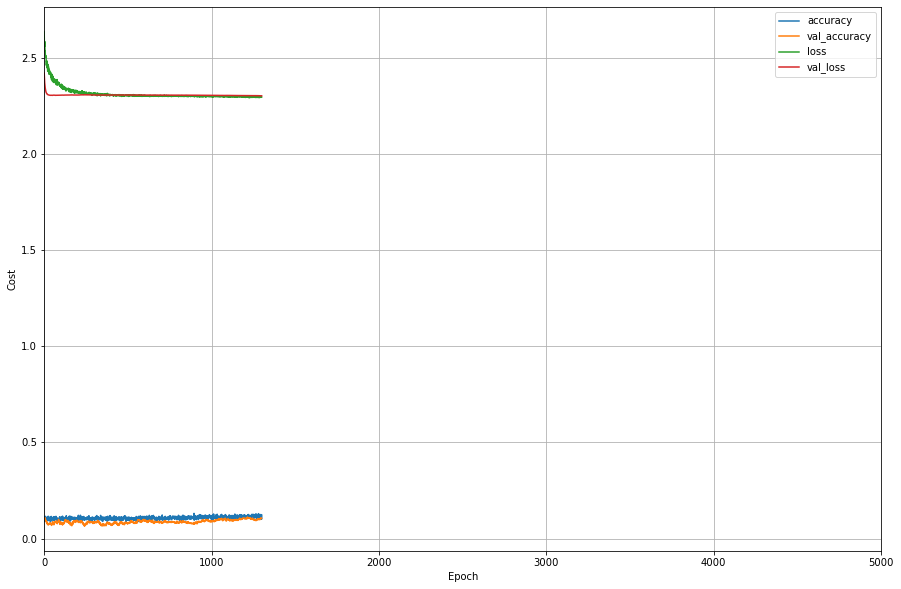

In [19]:
plot_loss(history, [0, 5000])

#plot_train_scatter(dnn_model, train_set, train_sems)

In [20]:
preds = [0.3, 0.4, 0.5]
confs = [0.6, 0.8, 0.4]
print(np.average(preds, weights=confs))
print()

0.3888888888888889



In [21]:
test_predictions = dnn_model.predict(test_set1)
test_predictions_classes = [np.argmax(preds) for preds in test_predictions]

print(bin_means)
print()
weights_preds = []
for pred_outputs, true_class, true_sem_val in zip(test_predictions, upper_test_sems, upper_test_sems_values):
    print(pred_outputs, true_class, true_sem_val)
    weighted = np.average(np.linspace(1, n_classes, n_classes), weights=pred_outputs)
    weights_preds.append(weighted)
    print(weighted)
    print()


[0.037323391905795124, 0.06372858055035689, 0.08565619203872002, 0.10879874996340742, 0.13236577492283727, 0.16417219215851456, 0.21990356735732883, 0.35975452947475794, 0.8331861684504355, 8.428420829186663]

[0.12311513 0.10782591 0.1123725  0.09583191 0.09347887 0.09195836
 0.08952145 0.08859906 0.1012882  0.09600867] 3.0 0.0985793916458202
5.285479402974862

[0.11423022 0.10634615 0.10796215 0.09981609 0.09557744 0.09392911
 0.09477094 0.09374624 0.09721716 0.09640448] 4.0 0.13378023550637094
5.343900993702583

[0.11356947 0.10800052 0.10833258 0.09439426 0.09044698 0.09068646
 0.09422418 0.09330823 0.10695454 0.10008285] 7.0 0.3865977198052777
5.397953070852677

[0.13546012 0.1078328  0.1058934  0.09200508 0.09974274 0.08749189
 0.09066935 0.08537978 0.09942012 0.09610464] 8.0 0.7004598826507766
5.234042796048731

[0.0882087  0.10319059 0.10823517 0.10372748 0.08564351 0.09826756
 0.10093082 0.10714281 0.10167044 0.10298296] 0.0 0.03672974670899142
5.5605497854702275

[0.10922851 


[0.10854001 0.10222636 0.10086613 0.09453385 0.0952341  0.1003056
 0.10299368 0.09589209 0.09884709 0.10056104] 1.0 0.06925395146459151
5.455057588521099

[0.10360958 0.10431343 0.10940293 0.10173217 0.09157313 0.09578141
 0.09637718 0.09950364 0.09870652 0.09900003] 4.0 0.1439548597672355
5.428956242532842

[0.09994414 0.1089847  0.10838483 0.09842709 0.08587763 0.09133929
 0.09602474 0.10056223 0.10691661 0.10353878] 3.0 0.10295983637827018
5.488508344210311

[0.10665654 0.10332267 0.10223334 0.0955634  0.09337164 0.09816716
 0.10119212 0.09750631 0.10037199 0.10161489] 6.0 0.2413265310207313
5.466008481904549

[0.11463854 0.10727823 0.1093528  0.09429689 0.09094448 0.09041454
 0.09384174 0.09309731 0.10664827 0.09948711] 7.0 0.3030444128130048
5.388027304919811

[0.12855639 0.10910376 0.11052118 0.09646916 0.09731553 0.08674042
 0.088856   0.08658349 0.0991037  0.09675035] 8.0 0.6639209317651763
5.245321096817562

[0.10025463 0.10868805 0.11026742 0.09952108 0.08544286 0.09228706
 

 0.09502739 0.09121297 0.10116867 0.09955911] 3.0 0.1191604532388995
5.350099417570216

[0.08945117 0.0984212  0.10009695 0.09991647 0.09067641 0.10508256
 0.10904015 0.10679878 0.09821472 0.10230152] 5.0 0.16991870909131776
5.5947470900657

[0.08773595 0.09992545 0.10113578 0.10082518 0.0892539  0.10164563
 0.10713898 0.10798881 0.09994152 0.10440881] 9.0 24.15699243511921
5.60788327294762

[0.10390352 0.10745333 0.11222797 0.10035019 0.08739012 0.09441101
 0.09407256 0.09824071 0.10364575 0.09830479] 8.0 0.6997497826211883
5.42060501086887

[0.10476261 0.10937108 0.10869379 0.09737118 0.08715721 0.09076233
 0.09482749 0.09780062 0.10682312 0.10243059] 2.0 0.08029039526275142
5.451342159469659

[0.08368648 0.10342727 0.10695668 0.10334036 0.08315676 0.09728
 0.10252894 0.11108592 0.10466885 0.10386869] 4.0 0.14273055651730635
5.6113331115196035

[0.08959126 0.09854653 0.10032809 0.09980845 0.0905946  0.10468055
 0.10853087 0.10694622 0.0984204  0.10255298] 8.0 0.7753558422678583
5.594

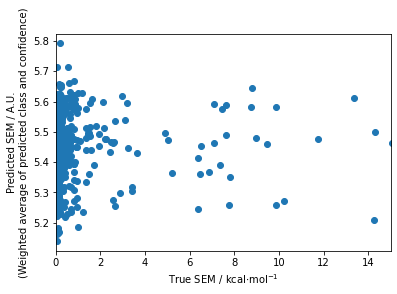

0.061916619614096634

In [22]:
plt.scatter(upper_test_sems_values, weights_preds)
# plt.ylim(0.7, 1.5)
plt.xlim(0, 15)
plt.ylabel("Predicted SEM / A.U.\n(Weighted average of predicted class and confidence)")
plt.xlabel("True SEM / kcal$\cdot$mol$^{-1}$")
plt.show()
stats.kendalltau(upper_test_sems, test_predictions_classes)[0]

In [23]:
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.svm import SVC 

model = SVC()


param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1) 
  
# fitting the model for grid search 
grid.fit(np.array(train_set), np.array(train_sems)) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  1.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [24]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [25]:
grid_predictions = grid.predict(test_set1) 
  
# print classification report 
print(classification_report(upper_test_sems, grid_predictions)) 

              precision    recall  f1-score   support

         0.0       0.24      0.33      0.28        63
         1.0       0.23      0.20      0.21        70
         2.0       0.19      0.22      0.21        58
         3.0       0.05      0.04      0.05        67
         4.0       0.22      0.12      0.16        91
         5.0       0.18      0.12      0.15        81
         6.0       0.16      0.18      0.17        71
         7.0       0.14      0.28      0.18        69
         8.0       0.17      0.12      0.14        75
         9.0       0.20      0.19      0.20        69

    accuracy                           0.18       714
   macro avg       0.18      0.18      0.17       714
weighted avg       0.18      0.18      0.17       714



In [26]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state = 1)

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30, 50]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 5, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(np.array(train_set), np.array(train_sems))

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2410 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  7.3min finished


In [27]:
# print best parameter after tuning 
print(gridF.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(gridF.best_estimator_) 

{'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


In [28]:
grid_predictions = gridF.predict(test_set1) 
  
# print classification report 
print(classification_report(upper_test_sems, grid_predictions)) 

              precision    recall  f1-score   support

         0.0       0.30      0.44      0.36        63
         1.0       0.14      0.11      0.13        70
         2.0       0.21      0.24      0.23        58
         3.0       0.10      0.09      0.09        67
         4.0       0.18      0.10      0.13        91
         5.0       0.14      0.10      0.12        81
         6.0       0.15      0.13      0.14        71
         7.0       0.23      0.32      0.27        69
         8.0       0.32      0.28      0.30        75
         9.0       0.31      0.48      0.37        69

    accuracy                           0.22       714
   macro avg       0.21      0.23      0.21       714
weighted avg       0.21      0.22      0.21       714



In [29]:
grid_predictions

array([6., 8., 8., 9., 9., 2., 9., 1., 2., 2., 5., 8., 9., 3., 7., 3., 8.,
       9., 6., 4., 5., 9., 9., 0., 2., 2., 2., 7., 7., 1., 2., 8., 8., 3.,
       0., 7., 7., 8., 9., 8., 0., 8., 3., 7., 1., 1., 8., 9., 4., 1., 4.,
       9., 7., 1., 2., 3., 9., 9., 7., 1., 8., 2., 3., 5., 2., 9., 8., 6.,
       0., 2., 0., 7., 2., 7., 5., 7., 9., 6., 9., 9., 1., 0., 2., 2., 6.,
       6., 6., 4., 4., 7., 0., 9., 7., 0., 8., 7., 8., 6., 0., 9., 1., 7.,
       0., 3., 7., 4., 7., 1., 2., 6., 5., 8., 3., 8., 0., 8., 4., 5., 0.,
       0., 0., 0., 9., 4., 5., 3., 0., 7., 5., 8., 7., 0., 9., 9., 2., 5.,
       5., 9., 2., 3., 4., 2., 6., 9., 9., 0., 9., 2., 5., 2., 0., 2., 2.,
       6., 8., 8., 7., 1., 4., 9., 2., 8., 8., 3., 6., 2., 8., 1., 3., 3.,
       7., 7., 5., 3., 3., 9., 0., 8., 2., 0., 2., 0., 7., 0., 8., 6., 5.,
       3., 1., 9., 7., 1., 4., 8., 9., 7., 9., 7., 9., 1., 4., 4., 7., 7.,
       8., 5., 6., 7., 2., 0., 7., 6., 9., 4., 0., 5., 3., 9., 7., 8., 0.,
       3., 7., 7., 0., 0.

In [30]:
upper_test_sems

array([3., 4., 7., 8., 0., 4., 1., 3., 6., 0., 4., 5., 3., 4., 6., 2., 3.,
       3., 5., 2., 4., 4., 9., 8., 1., 1., 4., 3., 6., 4., 8., 6., 8., 0.,
       0., 6., 5., 8., 9., 8., 6., 4., 1., 5., 4., 4., 6., 5., 4., 3., 2.,
       7., 8., 4., 4., 4., 9., 2., 1., 0., 1., 1., 5., 6., 5., 7., 1., 5.,
       1., 2., 7., 6., 1., 6., 6., 7., 6., 5., 7., 6., 5., 9., 0., 6., 5.,
       6., 4., 1., 3., 7., 4., 5., 2., 6., 8., 8., 6., 5., 8., 8., 5., 4.,
       2., 0., 8., 2., 3., 6., 2., 3., 7., 9., 2., 5., 0., 8., 9., 4., 7.,
       9., 9., 3., 6., 5., 3., 7., 2., 4., 1., 9., 7., 2., 5., 3., 4., 7.,
       3., 1., 0., 3., 4., 5., 5., 2., 0., 0., 9., 3., 6., 9., 0., 6., 1.,
       6., 7., 7., 7., 8., 4., 4., 0., 5., 7., 4., 3., 2., 8., 2., 6., 1.,
       7., 9., 3., 2., 3., 7., 1., 8., 4., 7., 4., 7., 8., 3., 3., 6., 7.,
       4., 2., 1., 7., 0., 9., 8., 0., 8., 3., 8., 5., 4., 1., 4., 4., 4.,
       9., 2., 0., 3., 2., 0., 8., 2., 4., 1., 3., 7., 4., 6., 2., 9., 7.,
       5., 8., 6., 5., 0.

Text(0, 0.5, 'Predicted SEM classes')

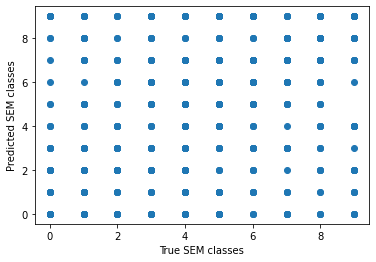

In [31]:
plt.scatter(upper_test_sems, grid_predictions)
plt.xlabel("True SEM classes")
plt.ylabel("Predicted SEM classes")

In [32]:
stats.kendalltau(upper_test_sems, grid_predictions)[0]

0.2863576154546959

In [33]:
# from sklearn.ensemble import RandomForestRegressor
# forest = RandomForestClassifier(random_state = 1)

# n_estimators = [100, 300, 500, 800, 1200]
# max_depth = [5, 8, 15, 25, 30, 50]
# min_samples_split = [2, 5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10] 

# hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

# gridF = GridSearchCV(forest, hyperF, cv = 5, verbose = 1, 
#                       n_jobs = -1)
# bestF = gridF.fit(np.array(train_set), np.array(train_sems))
print(train_set.shape)

(2853, 47)
